Данная тетрадка начинает серию тетрадок по генерации изображений.<br>
В данном проекте мы будем учиться генерировать изображения аквариумных рыб, в частности, так называемых "рыбок килли".

## Собираем датасет

Так как я не нашел подобный датасет в открытом доступе, то придется собрать картинки из выдачи изображений Google.<br>
Делать это мы будем при помощи библиотеки `google_images_download`.<br>
В нашем случае изображения будут скачиваться в папку `./downloads`.

In [11]:
from google_images_download import google_images_download

response = google_images_download.googleimagesdownload()
absolute_image_paths = response.download({
    'keywords': """killi fish,\
    рыбки килли,\
    Афиосемион Валкера,\
    Афиосемион Сплендид,\
    Epiplatys annulatus,\
    Нотобранх Кортхаус,\
    Nothobranchius korthausae,\
    Nothobranchius eggersi,\
    Нотобранхиус Фоерши,\
    Aplocheilus lineatus,\
    Краснопятнистый Панхакс,\
    Эпиплятис ламотта,\
    Epiplatys lamottei,\
    Шестиполосый Панхакс,\
    Эпиплатис шестиполосый,\
    Epiplatys sexfasciatus,\
    Эпиплатис Дагета,\
    Epiplatys dageti""",
    'limit': 50,
    'print_urls': False,
    'chromedriver': '/usr/bin/chromedriver',
    'delay': 0.1,
    'color_type': 'full-color',
    'format': 'jpg',
    'size': '>400*300',
    'no_directory': True
})

Заведем переменную для хранения абсолютого адреса папки, в которую скачались картинки.

In [1]:
downloads = 'absolute_path_to_downloads'

In [10]:
import os
import cv2
from tqdm import tqdm_notebook

Удалим изображения, которые были повреждены.

In [18]:
def removeInvalidImages(download_path, logname):
    with open(logname, 'w') as out:
        s = ''
        for img in tqdm_notebook(os.listdir(download_path)):
            try:
                question = cv2.imread(os.path.join(download_path, img))
                if question is None:
                    s += img + "\n"
                    os.remove(os.path.join(download_path, img))
            except Exception as e:
                s += str(e) + "\n"
        out.write(s)

In [49]:
removeInvalidImages(downloads, 'invalid-images-log.txt')

Имена некоторых файлов довольно длинные, что может помешать нам при аугментации собранных данных.<br>Поэтому их следует упростить

In [19]:
def imageNamesSimplification(path, logname):
    counter = 0
    with open(logname, 'w') as out:
        s = ''
        for img in tqdm_notebook(os.listdir(path)):
            try:
                filename = os.path.join(path, img)
                future_name = '/'.join(filename.split('/')[:-1]) + '/' + str(counter) + '.jpg'
                os.rename(filename, future_name)
                counter += 1
            except Exception as e:
                s += str(e) + "\n"
        out.write(s)

In [51]:
imageNamesSimplification(downloads, 'simplification-log.txt')

Также удалим дополнительную информацию, записанную в jpeg-файл, т.к. это может помешать при аугментации.
<br>
В этом нам поможет библиотека `piexif`.

In [55]:
from tqdm import tqdm
import piexif

# rename files
counter = 0
for filename in tqdm(filenames):
    try:
        piexif.remove(filename)
    except Exception as e:
        print('Hey! There is an exception!')
        print(e)
        print()

100%|██████████| 863/863 [00:01<00:00, 533.32it/s] 


Теперь почистим выкачанные данные руками, чтобы исключить некоторые нерелевантные изображения.

## Генерируем датасет для обучения

В `jupyter notebook` есть магические команды, так, например, можно использовать консоль из тетрадки, начав команду с `!`.<br>
Так даваете создадим папку для будущего датасета!

In [201]:
!mkdir dataset
# путь до папки в которую будет сгенерирован датасет
output = 'absolute_path_to_dataset'

Для генерации датасета, на котором мы будем тренировать модель, в данном проекте будут использованы `Augmentor` и `imgaug`.<br>
Установить их также можно прямо из тетрадки.

In [203]:
!pip3 install Augmentor imgaug

In [3]:
def get_filenames(path):
    return [os.path.join(path, name) for name in os.listdir(path) if os.path.isfile(os.path.join(path, name))]

Получим абсолютные пути до скачанных файлов...

In [9]:
filenames = get_filenames(downloads)

...и посмотрим на их количество

In [53]:
len(filenames)

863

## Генерируем изображения с Augmentor

In [204]:
import Augmentor

def augmentor_pipeline(path, output):
    p = Augmentor.Pipeline(path, output)

    p.rotate(0.7, max_left_rotation=10, max_right_rotation=10)
    p.flip_left_right(0.6)
    p.random_color(0.45, 1.1, 1.7)
    p.random_brightness(0.37, 0.95, 1.3)
    p.crop_random(probability=1., percentage_area=0.95)
    p.resize(probability=1, width=120, height=120)
    p.sample(len(p.augmentor_images) // 10 * 1000)#, multi_threaded=False)

In [10]:
augmentor_pipeline(downloads, output)

Executing Pipeline:   0%|          | 0/81000 [00:00<?, ? Samples/s]

Initialised with 814 image(s) found.
Output directory set to /home/nizhikebinesi/Desktop/killifish_generation/dataset.

Processing <PIL.Image.Image image mode=RGB size=120x120 at 0x7F5B842EF080>: 100%|██████████| 81000/81000 [41:22<00:00, 32.63 Samples/s]    


## Генерируем изображения с imgaug

Я буду создавать новые изображения из уже сгенерированных `Augmentor`'ом и, чтобы не смешивать получившиеся данные, буду сохранять полученное при помощи `imgaug` в другую папку(`dataset1`).

In [12]:
!mkdir dataset1

In [179]:
filenames = get_filenames(output)
output1 = 'absolute_path_to_dataset1'

In [181]:
import imgaug as ia
from imgaug import augmenters as iaa
import numpy as np

Возьмем случайные 5500 изображений для дополнительной аугментации.

In [182]:
np.random.shuffle(filenames)
filenames = filenames[:5500]

Очистим память от мусора(необязательный этап).

In [183]:
import gc
gc.collect()

0

In [185]:
import numpy as np
import cv2

images = np.zeros(shape=(5500, 120, 120, 3))
for idx, img_path in enumerate(tqdm_notebook(filenames)):
    img = cv2.imread(img_path, 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    images[idx, :, :, :] = img

Посмотрим на одно из выбранных изображений.

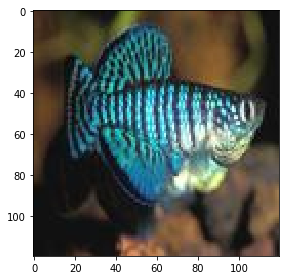

In [193]:
from skimage.io import imshow
np.random.seed(40178492)

imshow(images[np.random.randint(0, 5500)] / 255);

In [194]:
from imageio import imwrite
#from skimage import img_as_ubyte
from imgaug import augmenters as iaa

seq = iaa.Sequential([
    iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5), random_state=42),
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5, random_state=42), # add gaussian noise to images
    iaa.SaltAndPepper(p=0.02, random_state=42),
    iaa.Fliplr(p=0.3, random_state=42),
    iaa.GaussianBlur(sigma=(0, 0.5)) # blur images with a sigma of 0 to 0.5
])

In [197]:
images_aug = seq.augment_images(images)
for i, image_aug in enumerate(tqdm_notebook(images_aug)):
    imwrite(output1 + "/" + "image_%06d.jpg" % (i,), image_aug.astype(np.uint8))

Ура, получилось!

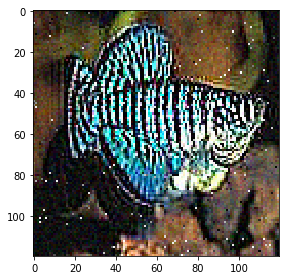

In [198]:
from skimage.io import imshow
np.random.seed(40178492)

imshow(images_aug[np.random.randint(0, 5500)] / 255);

## Собираем датасет и сжимаем в zip

In [12]:
%%time
import zipfile

dataset_name = 'fish_dataset.zip'
dataset = zipfile.ZipFile(dataset_name, 'w')

filenames = get_filenames(output) + get_filenames(output1)

for file in tqdm_notebook(filenames):
    dataset.write(file, compress_type=zipfile.ZIP_DEFLATED)
dataset.close()


CPU times: user 21.3 s, sys: 2.65 s, total: 24 s
Wall time: 26.9 s


Теперь у нас есть датасет, для того чтобы начать обучать генеративные модели!<br>
Увидимся в следующей тетрадке!..